## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845528,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783760,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330803,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083748,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757298,5283900
...,...,...,...,...,...,...
2024-02-23,64.959999,65.930000,64.949997,65.830002,65.830002,7388200
2024-02-26,66.080002,66.370003,65.750000,65.930000,65.930000,4597900
2024-02-27,65.940002,66.459999,65.769997,66.330002,66.330002,4433500


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
26/26 - 34s - 1s/step - loss: 0.0401
Epoch 2/50
26/26 - 4s - 168ms/step - loss: 0.0095
Epoch 3/50
26/26 - 5s - 199ms/step - loss: 0.0066
Epoch 4/50
26/26 - 3s - 97ms/step - loss: 0.0064
Epoch 5/50
26/26 - 3s - 116ms/step - loss: 0.0059
Epoch 6/50
26/26 - 3s - 117ms/step - loss: 0.0060
Epoch 7/50
26/26 - 4s - 135ms/step - loss: 0.0066
Epoch 8/50
26/26 - 5s - 181ms/step - loss: 0.0056
Epoch 9/50
26/26 - 3s - 114ms/step - loss: 0.0053
Epoch 10/50
26/26 - 4s - 161ms/step - loss: 0.0054
Epoch 11/50
26/26 - 3s - 115ms/step - loss: 0.0052
Epoch 12/50
26/26 - 3s - 103ms/step - loss: 0.0053
Epoch 13/50
26/26 - 5s - 200ms/step - loss: 0.0051
Epoch 14/50
26/26 - 3s - 106ms/step - loss: 0.0051
Epoch 15/50
26/26 - 3s - 104ms/step - loss: 0.0048
Epoch 16/50
26/26 - 3s - 103ms/step - loss: 0.0045
Epoch 17/50
26/26 - 3s - 113ms/step - loss: 0.0040
Epoch 18/50
26/26 - 4s - 152ms/step - loss: 0.0039
Epoch 19/50
26/26 - 4s - 138ms/step - loss: 0.0042
Epoch 20/50
26/26 - 3s - 123ms/step - loss:

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step


## Calculate the error of the model

In [12]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: ", test_mape)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAPE on Test set:  0.022309275770103894
RMSE on Test set:  1.7713984286546063
MSLE on Test set:  0.000697767985915866


## Predict Close price for 90 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Predict Close price for 90 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_90_days = []

for i in range(90):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_90_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━

In [14]:
# Show the result of predict 90 next days 
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1))
print(y_next_90_days.flatten())

[65.329475 64.98586  64.62924  64.30432  64.01331  63.747627 63.501278
 63.272823 63.063168 62.873478 62.70396  62.553467 62.420166 62.301685
 62.19543  62.09893  62.009823 61.925995 61.845707 61.76745  61.69004
 61.61266  61.534664 61.455746 61.375668 61.29448  61.21223  61.129154
 61.045452 60.96149  60.87748  60.7936   60.710106 60.627174 60.54501
 60.463715 60.383366 60.304047 60.225777 60.148594 60.07251  59.997475
 59.92355  59.850655 59.77866  59.707657 59.63772  59.568714 59.500603
 59.43335  59.366882 59.30117  59.236168 59.171886 59.108337 59.04554
 58.98335  58.921833 58.86098  58.80085  58.741432 58.682617 58.624485
 58.567036 58.510254 58.45414  58.39869  58.343895 58.28975  58.236248
 58.18338  58.131138 58.079517 58.0285   57.97808  57.92825  57.879
 57.830326 57.782207 57.734646 57.687626 57.641148 57.595203 57.549774
 57.50487  57.460476 57.416584 57.37319  57.330296 57.287888]


## Model visualization

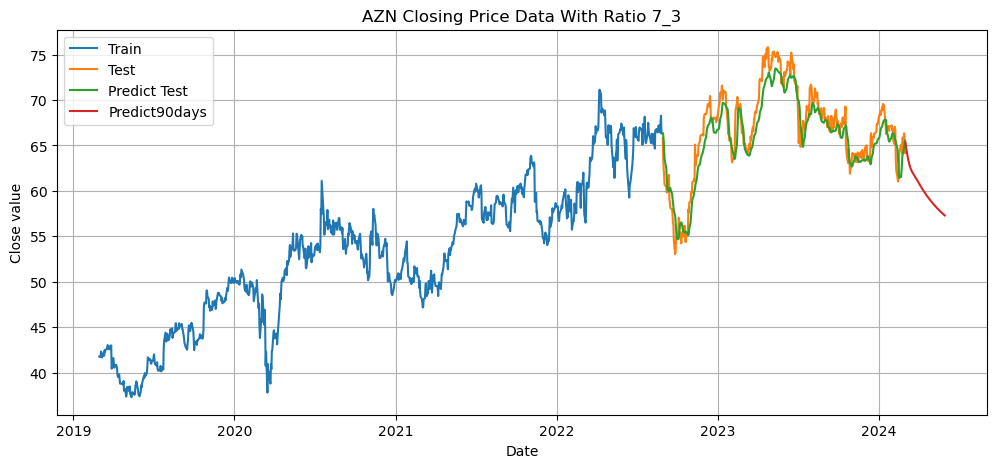

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 90 next days
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict90days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 7_3")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_73_90days_AZN.png')
plt.show()